In [1]:
import torch
import torchvision

import torchvision.datasets as dset
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from mpl_toolkits.mplot3d import axes3d
from torchvision.datasets import MNIST
import torch.nn.functional as F
import os
import pylab
import math
import matplotlib.pyplot as plt


In [2]:
# 長田さんコード
def select_device():
    # “”"GPU もしくは CPU の選択“”"
    if torch.cuda.is_available():
        device = torch.device('cuda')
        print('cuda is selected as device!')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        print('mps is selected as device!')
    else:
        device = torch.device('cpu')
        print('cpu....f')
    return device
device = select_device()

mps is selected as device!


0
1 23925.19140625
2 21605.720703125
3 20490.173828125
4 20885.267578125
5 20507.83203125
6 19916.009765625
7 20280.470703125
8 19743.62109375
9 18880.994140625
10 19412.88671875
11 19545.85546875
12 19222.568359375
13 19059.98046875
14 19218.5859375
15 19637.91015625
16 19146.3828125
17 18844.4609375
18 19134.115234375
19 19256.57421875
20 18853.232421875
21 18931.265625
22 18871.03125
23 19464.48046875
24 18966.09765625
25 19083.470703125
26 18518.408203125
27 19440.947265625
28 19000.822265625
29 18464.025390625
30 18608.3515625
31 18945.587890625
32 18391.916015625
33 19028.4375
34 18788.47265625
35 18961.37890625
36 18855.44921875
37 18792.88671875
38 18942.974609375
39 18711.0078125
40 18001.185546875
41 18336.330078125
42 18079.529296875
43 18500.76171875
44 18108.48828125
45 17854.62109375
46 18390.578125
47 18509.1171875
48 18194.5078125
49 18107.794921875
50 18229.166015625
51 18371.400390625
52 17857.18359375
53 18176.421875
54 18167.052734375
55 18402.634765625
56 18050.140

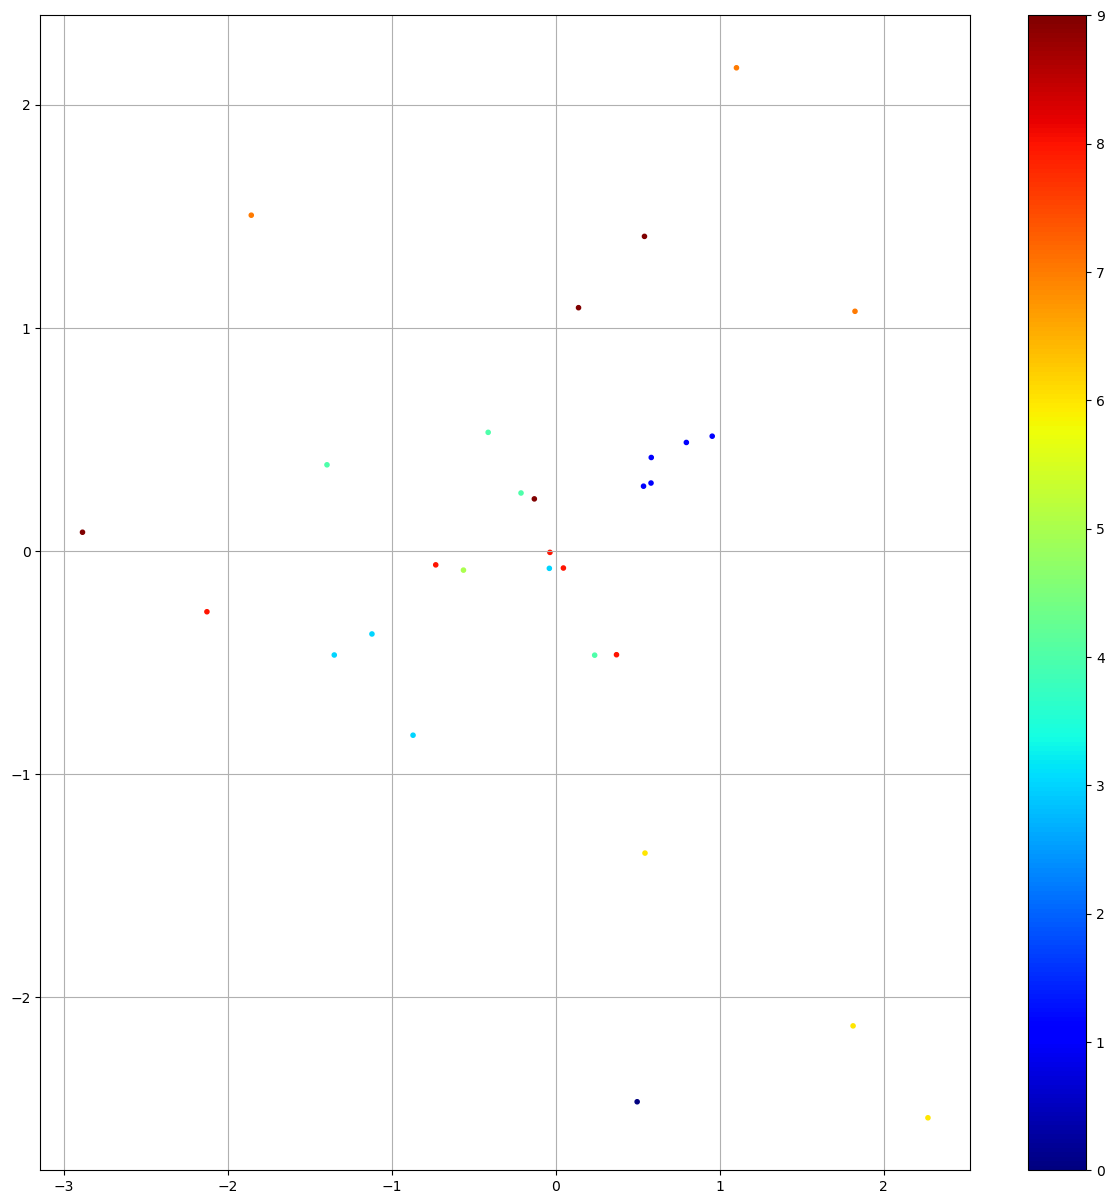

In [3]:

#カレントディレクトリにdc_imgというフォルダが作られる
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')
    
#カレントディレクトリにdataというフォルダが作られる
if not os.path.exists('./data'):
    os.mkdir('./data')
    

num_epochs = 5#エポック数 
batch_size = 30  #バッチサイズ
learning_rate = 1e-3   #学習率

train =True#Trueなら訓練用データ、Falseなら検証用データを使う
pretrained =False #学習済みのモデルを使うときはここをTrueに
latent_dim = 2  #最終的に落とし込む次元数
save_img = True   #元画像と再構成画像を保存するかどうか、バッチサイズが大きいときは保存しない方がいい

def to_img(x):
    x = x
    x = x.clamp(0, 1)
    
    return x

#画像データを前処理する関数
transform = transforms.Compose([
    
    transforms.RandomResizedCrop(32, scale=(1.0, 1.0), ratio=(1., 1.)),
    transforms.ToTensor(), 
    ])
    
#このコードで自動で./data/以下にm-nistデータがダウンロードされる
trainset = torchvision.datasets.MNIST(root='./data/', 
                                        train=True,
                                        download=True,
                                        transform=transform)

#このコードで自動で./data/以下にm-nistデータがダウンロードされる
testset = torchvision.datasets.MNIST(root='./data/', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
#学習時なら訓練用データを用いる
if train:
    dataloader = DataLoader(trainset,
                            
                            batch_size=batch_size, shuffle=True)
    
#テスト時なら検証用データを用いる
else:
    dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

#ネットワーク定義
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, stride=1, padding=1),  # b, 64, 32, 32
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0,True),            
            nn.MaxPool2d(2)  # b, 64, 16, 16
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1),  # b, 128, 16, 16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0,True),            
            nn.MaxPool2d(2)  # b, 128, 8, 8
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, stride=1, padding=1),  # b, 256, 8, 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0,True),            
            nn.MaxPool2d(2)  # b, 256, 4, 4
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, stride=1, padding=0),  # b, 512, 1, 1
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0,True),
        )
            

        self.mean = nn.Sequential(
            nn.Linear(512,latent_dim),# b, 512 ==> b, latent_dim
            )
        
        self.var = nn.Sequential(
            nn.Linear(512,latent_dim),# b, 512 ==> b, latent_dim
            )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim,512),# b, latent_dim ==> b, 512
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0,True),
            )
        self.convTrans1 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2,padding = 0),  # b, 256, 4, 4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0,True),
            )
        self.convTrans2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2,padding = 1),  # b, 128, 8, 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0,True),
            )
        self.convTrans3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2,padding = 1),  # b, 64, 16, 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0,True),
            )
        self.convTrans4 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, 4, stride=2,padding = 1),  # b, 3, 32, 32
            nn.BatchNorm2d(1),
            nn.Sigmoid()
            )

    #Encoderの出力に基づいてzをサンプリングする関数
    #誤差逆伝搬ができるようにreparameterization trickを用いる
    def _sample_z(self, mean, var):
      std = var.mul(0.5).exp_()
      eps = Variable(std.data.new(std.size()).normal_())
      return eps.mul(std).add_(mean)
    
    #Encoder
    def _encoder(self, x):
        x = self.conv1(x)      
        x = self.conv2(x)    
        x = self.conv3(x)     
        x = self.conv4(x)   
        x = x.view(-1,512)
        mean = self.mean(x)
        var = self.var(x)
        return mean,var
    
    #Decoder
    def _decoder(self, z):
      z = self.decoder(z)
      z = z.view(-1,512,1,1)
      x = self.convTrans1(z)
      x = self.convTrans2(x)
      x = self.convTrans3(x)
      x = self.convTrans4(x)
      return x
  
    def forward(self, x):
        # xは元画像　
        mean,var = self._encoder(x) #Decoderの出力はlog σ^2を想定
        z = self._sample_z(mean, var) #潜在変数の分布に基づいてzをサンプリング
        x = self._decoder(z) #サンプリングしたzに対して画像を再構成
        return x,mean,var,z
    
    def loss(self, x):
      mean, var = self._encoder(x) #Decoderの出力はlog σ^2を想定
      
      KL = -0.5 * torch.mean(torch.sum(1 + var- mean**2 - var.exp())) #KLダイバージェンス
      
      z = self._sample_z(mean, var) #潜在変数の分布に基づいてzをサンプリング
      y = self._decoder(z) #サンプリングしたzに対して画像を再構成
      delta = 1e-7 #logの中身がマイナスにならないように微小な値を与える
      reconstruction = torch.mean(torch.sum(x * torch.log(y+delta) + (1 - x) * torch.log(1 - y +delta))) #再構成誤差
      lower_bound = [-KL, reconstruction]                           
      return -sum(lower_bound),y,mean,var,z

def main():
    #ネットワーク宣言
    model = VAE(latent_dim).to(device)
    
    #事前に学習したモデルがあるならそれを使う
    if pretrained:
        param = torch.load('./conv_Variational_autoencoder_{}dim.pth'.format(latent_dim))
        model.load_state_dict(param)
    
    
    #最適化法はAdamを選択
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
    
                                 weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        itr = 0
        print(epoch)
        for data in dataloader:    
            itr+=1
            img, num = data            
            #img --> [batch_size,1,32,32]
            #num --> [batch_size,1]
            #imgは画像本体
            #numは画像に対する正解ラベル
            #ただし、学習時にnumは使わない
                
            #imgをデバイスに乗っける
            img = Variable(img).to(device)    
            # ===================forward=====================
            
            #outputが再構成画像、latentは次元削減されたデータ
            if train == False:
                output,mu,var,latent = model(img)            
            
            #学習時であれば、ネットワークパラメータを更新
            if train:
                #lossを計算
                #元画像と再構成後の画像が近づくように学習
                loss,output,mu,var,latent = model.loss(img)        
                # ===================backward====================
                #勾配を初期化
                optimizer.zero_grad()                
                #微分値を求める
                loss.backward()                
                #パラメータの更新
                optimizer.step()                
                print('{} {}'.format(itr,loss))
        # ===================log========================
            
    #データをtorchからnumpyに変換
    z = latent.cpu().detach().numpy()
    num = num.cpu().detach().numpy()
    
    #次元数が3の時のプロット
    if latent_dim == 3:
        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(z[:, 0], z[:, 1], z[:, 2], marker='.', c=num, cmap=pylab.cm.jet)
        for angle in range(0,360,60):
            ax.view_init(30,angle)
            plt.savefig("./fig{}.png".format(angle))
        
    #次元数が2の時のプロット
    if latent_dim == 2:
        plt.figure(figsize=(15, 15))
        plt.scatter(z[:, 0], z[:, 1], marker='.', c=num, cmap=pylab.cm.jet)
        plt.colorbar()
        plt.grid()
        plt.savefig("./fig.png")
    
    #元画像と再構成後の画像を保存するなら
    if save_img:
        value = int(math.sqrt(batch_size))
        pic = to_img(img.cpu().data)
        pic = torchvision.utils.make_grid(pic,nrow = value)
        save_image(pic, './dc_img/real_image_{}.png'.format(epoch))  #元画像の保存
        
        pic = to_img(output.cpu().data)
        pic = torchvision.utils.make_grid(pic,nrow = value)
        save_image(pic, './dc_img/image_{}.png'.format(epoch))  #再構成後の画像の保存
        
    #もし学習時ならモデルを保存
    #バージョン管理は各々で
    if train == True:
        torch.save(model.state_dict(), './conv_Variational_autoencoder_{}dim.pth'.format(latent_dim))

if __name__ == '__main__':
    main()